# Proyecto Limpieza de CSV 

El proyecto comienza con la obtención de datos en una página con este formato:

+ <img src="config\screenshots\Imagen0.PNG" width="680px" />

El problema surge cuando al obtener los datos, estos vienen en un formato no deseado, tal como se observa en las siguientes imagenes:

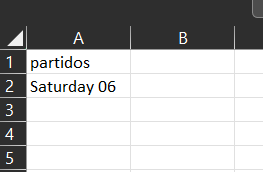

+ <img src="config\screenshots\Imagen2.PNG" width="480px" />

## Objetivo

Nuestro objetivo es lograr replicar la tabla que se encuentra alojada en la web, dentro de sus parametros tenemos que tiene 7 columnas y una infinidad de filas que contienen Fecha, Liga y Equipos

## Procesamiento

In [2]:
import pandas as pd
#import time
import datetime
import openpyxl
import os
import warnings

warnings.filterwarnings("ignore")

In [3]:
#fecha = datetime.date.today().strftime("%Y-%m-%d")
fecha = '2024-01-07'

In [4]:
### Creamos un diccionario para poder iterar en futuras tablas nuevas
archivos = [{'archivo':'goles_primer_tiempo_0_5'}]

In [5]:
### Abrimos el archivo csv
gol_primer_tiempo = pd.read_csv("input/Estadisticas_goles_primer_tiempo_0_5_{}.csv".format(fecha))
gol_primer_tiempo.head()

,partidos
0,"Saturday 06 January, 2024\nHome All Home Team ..."


In [7]:
### Separamos la fila en filas 
separar_df_filas = gol_primer_tiempo['partidos'].str.split('\n', expand=True).T
separar_df_filas.head()

,0
0,"Saturday 06 January, 2024"
1,Home All Home Team KO Away Team All Away
2,National League
3,54% 69%
4,Boreham Wood


Dentro de la tabla tenemos varios días por lo que necesitamos separar cada día en particular

In [9]:
# Función para encontrar el día de la semana en una fila
def encontrar_dia(fila):
    dias = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for dia in dias:
        if dia in fila:
            return dia
    return None

In [10]:
# Aplicar la función para crear una nueva columna 'dia'
separar_df_filas['dia'] = separar_df_filas[0].apply(encontrar_dia)
separar_df_filas

,0,dia
0,"Saturday 06 January, 2024",Saturday
1,Home All Home Team KO Away Team All Away,None
2,National League,None
3,54% 69%,None
4,Boreham Wood,None
...,...,...
1040,50% 50%,None
1041,Gent,None
1042,16:45,None
1043,Mechelen,None


In [14]:
### Verificamos si se crearon los días
separar_df_filas['dia'].value_counts()

dia
Saturday     2
Sunday       2
Monday       2
Wednesday    2
Thursday     2
Tuesday      1
Friday       1
Name: count, dtype: int64

Esta función toma un DataFrame como entrada y devuelve una lista de DataFrames, separados por día. Cada DataFrame en la lista contiene datos correspondientes a un día específico.

In [15]:
"""
separar_dataframes_por_dia(df)
    current_day: Variable que almacena el día actual mientras se recorre el DataFrame.

    current_dataframe: Lista que almacena los datos del DataFrame actual correspondientes al día actual.

    dataframes: Lista que almacenará los DataFrames separados por día.

    Se itera sobre las filas del DataFrame (df.iterrows()), y para cada fila:

    Se verifica si el valor en la columna 'day' no es nulo.
    Si current_day ya tiene un valor (no es la primera fila), se agrega un nuevo DataFrame a la lista dataframes que contiene los datos recopilados hasta ese momento.
    Se actualiza current_day con el valor actual de la columna 'day'.
    Se agrega el valor de la columna correspondiente a la lista current_dataframe.
    Después de salir del bucle, se verifica nuevamente si current_day tiene un valor, y si es así, se agrega el último DataFrame a la lista dataframes.

    La función devuelve la lista dataframes que contiene los DataFrames separados por día.
"""

def separar_dataframes_por_dia(df):
    current_day = None
    current_dataframe = []
    dataframes = []

    for index, row in df.iterrows():
                
        if row['dia'] is not None:
            if current_day is not None:
                dataframes.append(pd.DataFrame(current_dataframe, columns=[0]))
                current_dataframe = []
            current_day = row['dia']
        current_dataframe.append(row[0])

    if current_day is not None:
        dataframes.append(pd.DataFrame(current_dataframe, columns=[0]))

    return dataframes

In [16]:
dataframes = separar_dataframes_por_dia(separar_df_filas)
print(len(dataframes))

12


Trabajaremos con el día actual a modo de ejemplo

In [28]:
dia_3 = dataframes[2]
dia_3.head(20)

,0
0,"Monday 08 January, 2024"
1,Home All Home Team KO Away Team All Away
2,National League
3,N/A N/A
4,AFC Fylde
5,16:45
6,Hartlepool
7,65% 69%
8,31% 35%
9,Barnet


Utilizamos la misma lógica con las Ligas que con los días

In [22]:
# Función para encontrar la Liga en una fila
def encontrar_liga(fila):
    ligas = ['La Liga', # España
            'Segunda Division', # España
            'Bundesliga', # Alemania
            'Greek Super League', # Grecia
            'A League', # Australia
            'Serie A', # Italia
            'Serie B', # Italia
            'Scottish Championship', # Escocia
            'Scottish League 1', # Escocia
            'Scottish League 2', # Escocia
            'SPL', # Escocia
            'Portugese Liga NOS', # Portugal
            'Turkish Super Lig', # Turkia
            'Premier League', # Inglaterra
            'League One', # Inglaterra
            'League Two', # Inglaterra
            'National League', # Inglaterra
            'Championship', # Inglaterra
            'Ligue 1', # Francia
            'Ligue 2', # Francia
            'Eredivisie', # Holanda
            'Eerste Divisie', # Holanda
            'First Division B', # Belgica
            'Liga MX', # Mexico
            ]
    for liga in ligas:
        if liga in fila:
            return liga
    return None

In [23]:
def separar_dataframes_por_liga(df):
    current_liga = None
    current_dataframe = []
    listado_ligas = []

    for index, row in df.iterrows():
        if row['Liga'] is not None:
            if current_liga is not None:
                listado_ligas.append(pd.DataFrame(current_dataframe, columns=[0]))
                current_dataframe = []
            current_liga = row['Liga']
        current_dataframe.append(row[0])

    if current_liga is not None:
        listado_ligas.append(pd.DataFrame(current_dataframe, columns=[0]))

    return listado_ligas

In [24]:
### Función que elimina el encabezado y obtiene el día del partido
def obtener_ligas_por_dia(dataframe):
    dia_partido = dataframe[0].iloc[:1][0]
    partidos = dataframe[1:]
    partidos['Liga'] = partidos[0].apply(encontrar_liga)
    partidos = partidos.iloc[1:]

    listado_ligas = separar_dataframes_por_liga(partidos)
    
    return listado_ligas, dia_partido

In [34]:
### Función que elimina el encabezado y obtiene la Liga del partido
def obtener_nombre_liga(dataframes):
    liga_actual = dataframes.iloc[:1]
    liga_actual_valor = liga_actual.loc[0, 0]
    return liga_actual_valor

In [33]:
### Función que separa las ligas del día en diferentes dataframes
ligas, dia_partido = obtener_ligas_por_dia(dia_3)
print(dia_partido)
print(len(ligas))

Monday 08 January, 2024
4


In [31]:
ligas[1]

,0
0,Scottish League 1
1,11% 28%
2,Falkirk
3,16:45
4,Cove Rangers
5,56% 67%


Creamos una función que itera cada 5 filas para recrear la página donde se obtuvieron los datos

In [35]:
def crear_data(lista_partidos):
    
    liga_actual_valor = obtener_nombre_liga(lista_partidos)
    
    ### Eliminamos el nombre de la liga dado que ya lo obtuvimos
    lista_partidos = lista_partidos[1:]
    
    # Calcular el número de filas en el DataFrame
    num_filas = len(lista_partidos)
    # Calcular el número de grupos de datos (en este caso, 4 columnas)
    num_grupos = num_filas // 5
    
    data = {}

    # Iterar sobre los grupos de datos y dividirlos en las columnas correspondientes
    for i in range(num_grupos):
        fila_inicio = i * 5
        home_ida_vuelta = lista_partidos.iloc[fila_inicio, 0]
        equipo1 = lista_partidos.iloc[fila_inicio + 1, 0]
        hora = lista_partidos.iloc[fila_inicio + 2, 0]
        equipo2 = lista_partidos.iloc[fila_inicio + 3, 0]
        away_vuelta_ida = lista_partidos.iloc[fila_inicio + 4, 0]
        
        data.update({'home_ida_vuelta': data.get('home_ida_vuelta', []) + [home_ida_vuelta],
                    'Equipo 1': data.get('Equipo 1', []) + [equipo1],
                    'Hora': data.get('Hora', []) + [hora],
                    'Equipo 2': data.get('Equipo 2', []) + [equipo2],
                    'away_vuelta_ida': data.get('away_vuelta_ida', []) + [away_vuelta_ida]
                    })
    
    # Crear el dataframe a partir del diccionario
    new_df = pd.DataFrame(data)
    new_df[['Local_ida', 'Local_vuelta']] = new_df['home_ida_vuelta'].str.split(' ', expand=True)
    new_df[['Visita_ida', 'Visita_vuelta']] = new_df['away_vuelta_ida'].str.split(' ', expand=True)
    new_df = new_df.drop(['home_ida_vuelta','away_vuelta_ida'], axis=1)
    new_df = new_df[['Local_ida', 'Local_vuelta','Equipo 1', 'Hora', 'Equipo 2', 'Visita_ida', 'Visita_vuelta']]
    new_df['Liga'] = liga_actual_valor
    
    return new_df

Debemos juntar los dataframes en uno solo

In [36]:
df_consolidado_ligas = pd.DataFrame()
for i in range(len(ligas)):
    #print(ligas[i])
    df = ligas[i]
    df_liga = crear_data(df)
    df_liga['Día Partido'] = dia_partido
    df_consolidado_ligas = pd.concat([df_consolidado_ligas, df_liga], ignore_index=True)

df_consolidado_ligas

,Local_ida,Local_vuelta,Equipo 1,Hora,Equipo 2,Visita_ida,Visita_vuelta,Liga,Día Partido
0,N/A,N/A,AFC Fylde,16:45,Hartlepool,65%,69%,National League,"Monday 08 January, 2024"
1,31%,35%,Barnet,16:45,Dag and Red,46%,31%,National League,"Monday 08 January, 2024"
2,11%,28%,Falkirk,16:45,Cove Rangers,56%,67%,Scottish League 1,"Monday 08 January, 2024"
3,25%,41%,Peterhead,16:45,Dumbarton,31%,29%,Scottish League 2,"Monday 08 January, 2024"
4,50%,61%,Pendikspor,11:00,Antalyaspor,50%,75%,Turkish Super Lig,"Monday 08 January, 2024"
5,44%,39%,Alanyaspor,11:00,Ankaragucu,50%,63%,Turkish Super Lig,"Monday 08 January, 2024"
6,56%,56%,Kasimpasa,14:00,Buyuksehyr,56%,56%,Turkish Super Lig,"Monday 08 January, 2024"
7,33%,56%,Rizespor,14:00,Besiktas,44%,56%,Turkish Super Lig,"Monday 08 January, 2024"


Listo, hemos limpiado la data y obtenido el resultado esperado, además hemos agregado un filtro para la Liga y Día de Partido.
Por último, debemos guardar el archivo en nuestra carpeta output

In [39]:
df_consolidado_ligas.to_excel(f"output\Estadisticas_goles_primer_tiempo_{fecha}.xlsx", index= False)